In [66]:
import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import csv

## Data Description

    Date:    The date this data pertains to.
    Open:    The opening price for the asset on the given date.
    High:    The high price for the asset on the given date.
    Low:     Low proce for theasset on the given date
    close:   closing proce for the asset on given date.
    Volume:  The number of shares traded on IEX only.

In [67]:
# getting data from tiingo webesite using API 
'''
ticker name= stock name in tiingo website
Start Date= Date from when we need historical data of a stock(format YYYY-MM-DD)
resampleFreq = This allows you to set the frequency in which you want data resampled. For example "1hour" would return the data where OHLC is calculated on an hourly schedule.

'''
def data_extraction(ticker_name,startDate,resampleFreq,token):
    url="https://api.tiingo.com/iex/{}/prices?startDate={}&resampleFreq={}&columns=open,high,low,close,volume&token={}".format(ticker_name,startDate,resampleFreq,token)

    data=requests.get(url)
    dataset=data.json()
    #print(data.status_code)
    return dataset
    
json_dataset=data_extraction(ticker_name='aapl',startDate='2019-01-02',resampleFreq='1hour',token='a159a3a83b1754845d7353fbec1c9f2902d4a8e1')

In [68]:
stock_df=pd.json_normalize(json_dataset)
stock_df

,date,open,high,low,close,volume
0,2019-01-02T15:00:00.000Z,155.140,157.190,154.575,156.850,85705.0
1,2019-01-02T16:00:00.000Z,156.850,158.340,156.740,157.065,71070.0
2,2019-01-02T17:00:00.000Z,157.065,158.395,156.925,158.160,45895.0
3,2019-01-02T18:00:00.000Z,158.170,158.820,158.135,158.725,44166.0
4,2019-01-02T19:00:00.000Z,158.730,158.735,157.770,157.910,71703.0
...,...,...,...,...,...,...
8229,2023-07-05T18:00:00.000Z,190.950,191.445,190.605,191.300,73721.0
8230,2023-07-05T19:00:00.000Z,191.295,191.500,191.205,191.335,102588.0
8231,2023-07-05T20:00:00.000Z,191.295,191.500,191.205,191.335,0.0
8232,2023-07-06T14:00:00.000Z,189.820,190.205,189.485,189.565,105221.0


## checking NULL values

In [79]:
NULL_check=stock_df.isnull().sum()

if (NULL_check.values>0).any():
    print("Null values present")

else:
    print("No null values")


No null values


#### Observation:  
    NO null values 

## Checking data types

In [54]:
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8231 entries, 0 to 8230
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   date    8231 non-null   object 
 1   open    8231 non-null   float64
 2   high    8231 non-null   float64
 3   low     8231 non-null   float64
 4   close   8231 non-null   float64
 5   volume  8231 non-null   float64
dtypes: float64(5), object(1)
memory usage: 386.0+ KB


In [55]:
## converting date column into datetime format

stock_df['date']=pd.to_datetime(stock_df['date'])

## Checking data from period to period

In [56]:
stock_df.head(),stock_df.tail()

(                       date     open     high      low    close   volume
 0 2019-01-02 15:00:00+00:00  155.140  157.190  154.575  156.850  85705.0
 1 2019-01-02 16:00:00+00:00  156.850  158.340  156.740  157.065  71070.0
 2 2019-01-02 17:00:00+00:00  157.065  158.395  156.925  158.160  45895.0
 3 2019-01-02 18:00:00+00:00  158.170  158.820  158.135  158.725  44166.0
 4 2019-01-02 19:00:00+00:00  158.730  158.735  157.770  157.910  71703.0,
                           date     open     high      low    close    volume
 8226 2023-07-05 15:00:00+00:00  192.350  192.380  190.895  190.930  107552.0
 8227 2023-07-05 16:00:00+00:00  190.930  191.310  190.655  191.135   62051.0
 8228 2023-07-05 17:00:00+00:00  191.130  191.305  190.850  190.935   49983.0
 8229 2023-07-05 18:00:00+00:00  190.950  191.445  190.605  191.300   73721.0
 8230 2023-07-05 19:00:00+00:00  191.295  191.500  191.205  191.335  102588.0)

### Observation
    data is 
    starting--------------'2019-01-02'(yyy-mm-dd)
    till------------------'2023-07-05'

In [57]:
# using close column to predict the stock
close_stock=stock_df['close']

In [58]:
close_stock.tail()

8226    190.930
8227    191.135
8228    190.935
8229    191.300
8230    191.335
Name: close, dtype: float64

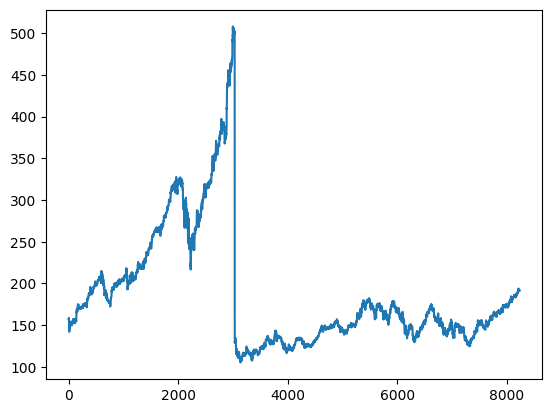

In [59]:
plt.plot(close_stock)

## Data Scaling 

        LSTM are sensitive to the scale of data. So we apply MinMax scaler

In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler(feature_range=(0,1))
close_stock=scaler.fit_transform(np.array(close_stock).reshape(-1,1))

In [61]:
close_stock

array([[0.12811666],
       [0.12865033],
       [0.13136829],
       ...,
       [0.21272107],
       [0.21362706],
       [0.21371393]])

## Train Test split

    >since the problem here is time series we dont use cross validation or random seed for train test split
    >the data is depend on previous data for any time series
        ex:- Day1  Day2  Day3
              120  130    145
              
              here day2 value depend on day1 stock close value

In [62]:
#Splitting train and test data

training_size=int(len(close_stock)*0.65) #65% train data
test_size=len(close_stock)-training_size  # 35% test size

In [63]:
training_size,test_size

(5350, 2881)

In [64]:
# we prepare train and test data by using above training_size and test_size

#since trainnig size is 5339 train data will be till 0 to 5350
train_data,test_data=close_stock[0:training_size],close_stock[training_size:len(close_stock),:1]

In [65]:
len(train_data),len(test_data)

(5350, 2881)

## Data Preprocessing